# CFP Visualization Report

Analysis of schedule inequality, prediction errors, and home field advantage.

In [12]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import defaultdict

# Import metrics module
import sys
sys.path.insert(0, os.path.abspath('..'))

from src.utils.metrics import calculate_schedule_inequality_index

# Set modern visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Enhanced plotting parameters for professional look
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'figure.facecolor': 'white',
    'axes.facecolor': '#f8f9fa',
    'axes.edgecolor': '#dee2e6',
    'axes.linewidth': 1.2,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.color': '#adb5bd',
    'grid.linestyle': '--',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 13,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'legend.framealpha': 0.9,
    'legend.edgecolor': '#dee2e6',
})

# Modern color palette
COLORS = {
    'primary': '#667eea',
    'secondary': '#764ba2',
    'accent': '#f093fb',
    'success': '#4facfe',
    'warning': '#fa709a',
    'danger': '#ee0979',
    'info': '#30cfd0',
    'light': '#a8edea',
}

# Configuration
year = 2025
week = 15

# Output directory
output_dir = Path('./data/output')
viz_dir = output_dir / 'visualizations'
viz_dir.mkdir(parents=True, exist_ok=True)

print(f'✨ CFP Visualization Report')
print(f'   Season: {year}, Week: {week}')
print(f'   Output: {viz_dir}')

✨ CFP Visualization Report
   Season: 2025, Week: 15
   Output: data/output/visualizations


In [13]:
# Cell 2: Load Data
# Load final composite rankings
rankings_df = pd.read_csv(output_dir / 'rankings' / f'composite_rankings_{year}_week{week}.csv')

# Load games data
def load_cached_games(year, week):
    cache_dir = f'./data/cache/{year}'
    parquet_path = f'{cache_dir}/games_w{week}.parquet'
    csv_path = f'{cache_dir}/games_w{week}.csv'
    
    if os.path.exists(parquet_path):
        try:
            return pd.read_parquet(parquet_path)
        except (ImportError, ModuleNotFoundError):
            pass
    
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    
    raise FileNotFoundError(f'No cached data found')

games_df = load_cached_games(year, week)

print(f'Loaded {len(rankings_df)} teams')
print(f'Loaded {len(games_df)} games')

Loaded 136 teams
Loaded 557 games


## Schedule Inequality

In [14]:
# Cell 3: Calculate Schedule Inequality by Conference
# Get team conferences from games data
team_conferences = {}
for _, game in games_df.iterrows():
    if 'home_conference' in game:
        team_conferences[game['home_team']] = game['home_conference']
        team_conferences[game['away_team']] = game['away_conference']

# Group teams by conference
conferences = defaultdict(list)
for team, conf in team_conferences.items():
    if conf:  # Only include teams with conferences
        conferences[conf].append(team)

# Calculate inequality index for each conference
conf_inequality = {}
conf_sos_data = {}

for conf, teams in conferences.items():
    if len(teams) < 2:
        continue
    
    # Get SOS scores for teams in this conference
    conf_sos = {}
    for team in teams:
        team_row = rankings_df[rankings_df['team'] == team]
        if not team_row.empty:
            conf_sos[team] = team_row.iloc[0]['sos']
    
    if len(conf_sos) >= 2:
        inequality = calculate_schedule_inequality_index(conf_sos)
        conf_inequality[conf] = inequality
        conf_sos_data[conf] = conf_sos

# Sort by inequality
sorted_inequality = sorted(conf_inequality.items(), key=lambda x: x[1], reverse=True)

print('='*80)
print('CONFERENCE SCHEDULE INEQUALITY')
print('='*80)
print()
print('Higher inequality = more unbalanced schedules within conference')
print()
for conf, ineq in sorted_inequality[:10]:
    print(f'{conf:30} {ineq:.4f}')

CONFERENCE SCHEDULE INEQUALITY

Higher inequality = more unbalanced schedules within conference

Big Ten                        0.0625
SEC                            0.0497
American Athletic              0.0471
Mountain West                  0.0428
Big 12                         0.0384
Conference USA                 0.0360
Mid-American                   0.0331
ACC                            0.0327
Pac-12                         0.0318
Sun Belt                       0.0262


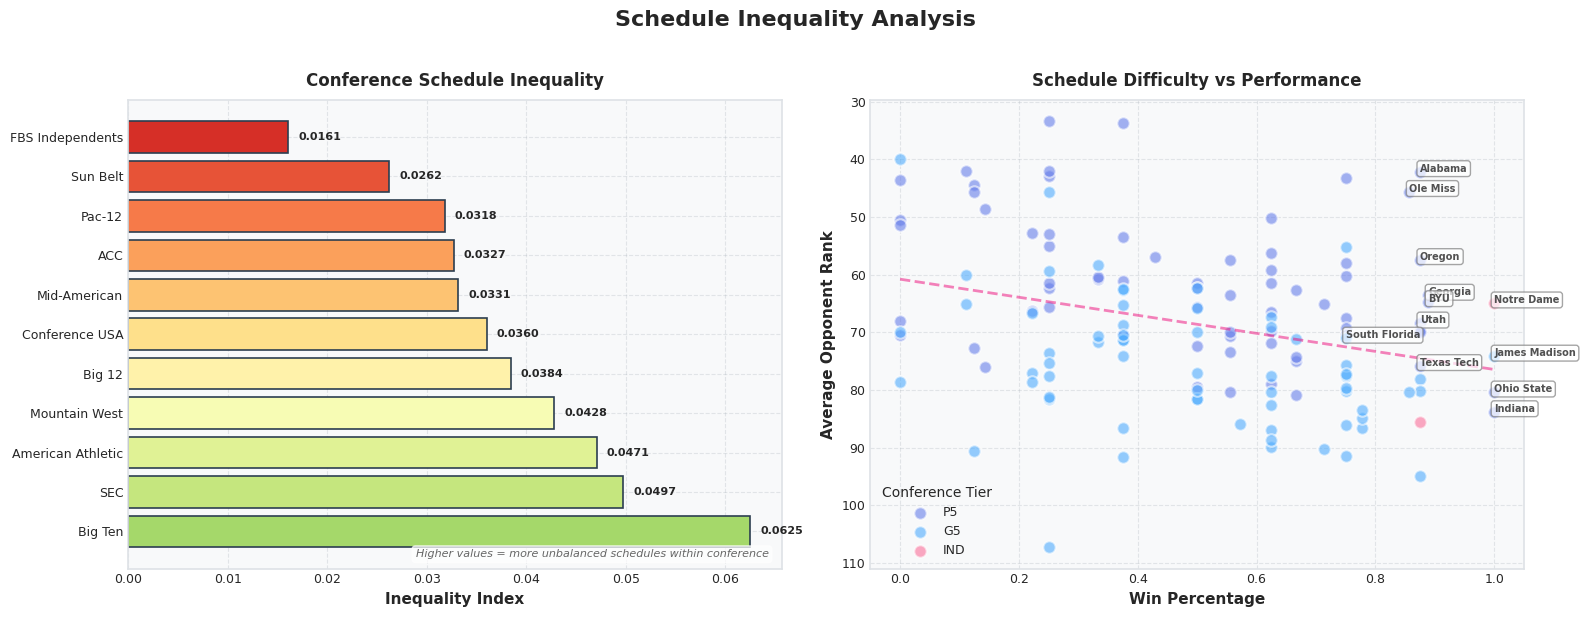

✅ Saved: data/output/visualizations/schedule_inequality_2025.png


In [15]:
# Cell 4: Visualize Schedule Inequality
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Schedule Inequality Analysis', fontsize=16, fontweight='bold', y=1.02)

# Plot 1: Conference inequality bar chart with gradient
ax1 = axes[0]
confs = [c for c, _ in sorted_inequality[:15]]
ineqs = [i for _, i in sorted_inequality[:15]]

# Create gradient color effect
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(confs)))
bars = ax1.barh(range(len(confs)), ineqs, color=colors, edgecolor='#2c3e50', linewidth=1.2)

# Add value labels
for i, (bar, ineq) in enumerate(zip(bars, ineqs)):
    ax1.text(ineq + 0.001, i, f'{ineq:.4f}', va='center', fontsize=8, fontweight='bold')

ax1.set_yticks(range(len(confs)))
ax1.set_yticklabels(confs, fontsize=9)
ax1.set_xlabel('Inequality Index', fontsize=11, fontweight='bold')
ax1.set_title('Conference Schedule Inequality', fontsize=12, fontweight='bold', pad=10)
ax1.set_facecolor('#f8f9fa')
ax1.grid(True, alpha=0.3, axis='x')

# Add explanation text
ax1.text(0.98, 0.02, 'Higher values = more unbalanced schedules within conference', 
         transform=ax1.transAxes, fontsize=8, style='italic', alpha=0.7,
         ha='right', va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Plot 2: Win% vs Avg Opponent Rank with color coding by conference tier
ax2 = axes[1]

# Add conference tier to rankings_df if not present
if 'conference_tier' not in rankings_df.columns:
    from src.utils.conference import get_conference_tier
    rankings_df['conference_tier'] = rankings_df['conference'].apply(lambda x: get_conference_tier(str(x)) if pd.notna(x) else 'IND')

# Calculate average opponent rank for each team
avg_opp_ranks = {}
for team in rankings_df['team']:
    team_games = games_df[(games_df['home_team'] == team) | (games_df['away_team'] == team)]
    opp_ranks = []
    
    for _, game in team_games.iterrows():
        opponent = game['away_team'] if game['home_team'] == team else game['home_team']
        opp_row = rankings_df[rankings_df['team'] == opponent]
        if not opp_row.empty:
            opp_ranks.append(opp_row.iloc[0]['rank'])
    
    if opp_ranks:
        avg_opp_ranks[team] = np.mean(opp_ranks)

rankings_df['avg_opp_rank'] = rankings_df['team'].map(avg_opp_ranks)
rankings_df['win_pct'] = rankings_df['wins'] / (rankings_df['wins'] + rankings_df['losses'])

# Color by conference tier
tier_colors = {'P5': COLORS['primary'], 'G5': COLORS['success'], 'IND': COLORS['warning']}
for tier, color in tier_colors.items():
    tier_data = rankings_df[rankings_df['conference_tier'] == tier]
    ax2.scatter(tier_data['win_pct'], tier_data['avg_opp_rank'], 
               alpha=0.6, s=80, color=color, label=tier, edgecolors='white', linewidth=1.5)

# Annotate top 12
top12 = rankings_df.head(12)
for _, row in top12.iterrows():
    if pd.notna(row['avg_opp_rank']):
        ax2.annotate(row['team'], (row['win_pct'], row['avg_opp_rank']), 
                    fontsize=7, alpha=0.8, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'))

ax2.set_xlabel('Win Percentage', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average Opponent Rank', fontsize=11, fontweight='bold')
ax2.set_title('Schedule Difficulty vs Performance', fontsize=12, fontweight='bold', pad=10)
ax2.invert_yaxis()
ax2.set_facecolor('#f8f9fa')
ax2.grid(True, alpha=0.3)
ax2.legend(title='Conference Tier', framealpha=0.9, edgecolor='#dee2e6')

# Add trendline
valid_data = rankings_df[rankings_df['avg_opp_rank'].notna()]
if len(valid_data) > 1:
    z = np.polyfit(valid_data['win_pct'], valid_data['avg_opp_rank'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(valid_data['win_pct'].min(), valid_data['win_pct'].max(), 100)
    ax2.plot(x_trend, p(x_trend), "--", color=COLORS['danger'], alpha=0.5, linewidth=2, label='Trend')

plt.tight_layout()
plt.savefig(viz_dir / f'schedule_inequality_{year}.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f'✅ Saved: {viz_dir}/schedule_inequality_{year}.png')

## Ranking Stability

In [16]:
# Cell 5: Load Historical Rankings (if available)
# Try to load rankings from previous weeks
historical_rankings = {}

for w in range(5, week + 1):  # Start from week 5 to avoid early season noise
    rankings_file = output_dir / 'rankings' / f'composite_rankings_{year}_week{w}.csv'
    if rankings_file.exists():
        historical_rankings[w] = pd.read_csv(rankings_file)

print(f'Loaded historical rankings for {len(historical_rankings)} weeks')
print(f'Weeks available: {sorted(historical_rankings.keys())}')

if len(historical_rankings) < 2:
    print()
    print('Note: Need rankings from multiple weeks for stability analysis.')
    print('Run previous weeks\' analyses to build historical data.')

Loaded historical rankings for 1 weeks
Weeks available: [15]

Note: Need rankings from multiple weeks for stability analysis.
Run previous weeks' analyses to build historical data.


In [17]:
# Cell 6: Visualize Ranking Trajectories
if len(historical_rankings) >= 2:
    fig, ax = plt.subplots(figsize=(16, 10))
    fig.patch.set_facecolor('white')
    
    # Get current top 25
    current_top25 = rankings_df.head(25)['team'].tolist()
    
    # Use modern color palette
    import matplotlib.cm as cm
    colors = cm.viridis(np.linspace(0, 1, 25))
    
    # Track each team's trajectory
    for idx, team in enumerate(current_top25):
        weeks = []
        ranks = []
        
        for w, df in sorted(historical_rankings.items()):
            team_row = df[df['team'] == team]
            if not team_row.empty:
                weeks.append(w)
                ranks.append(team_row.iloc[0]['rank'])
        
        if len(weeks) >= 2:
            ax.plot(weeks, ranks, marker='o', label=team, alpha=0.8, 
                   linewidth=2.5, markersize=6, color=colors[idx],
                   markeredgecolor='white', markeredgewidth=1.5)
    
    ax.invert_yaxis()
    ax.set_xlabel('Week', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rank', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 25 Ranking Trajectories - {year} Season', 
                fontsize=15, fontweight='bold', pad=15)
    ax.set_facecolor('#f8f9fa')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add horizontal lines for playoff cutoffs
    ax.axhline(y=4, color=COLORS['success'], linestyle='--', linewidth=2, alpha=0.5, label='First Round Bye')
    ax.axhline(y=12, color=COLORS['warning'], linestyle='--', linewidth=2, alpha=0.5, label='Playoff Cutoff')
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, 
             framealpha=0.95, edgecolor='#dee2e6', ncol=2)
    ax.set_ylim(26, 0)
    
    plt.tight_layout()
    plt.savefig(viz_dir / f'ranking_stability_{year}.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f'✅ Saved: {viz_dir}/ranking_stability_{year}.png')
else:
    print('⚠️  Skipping trajectory plot - need multiple weeks of data')
    print('   Run analyses for multiple weeks to generate this visualization')

⚠️  Skipping trajectory plot - need multiple weeks of data
   Run analyses for multiple weeks to generate this visualization


In [18]:
# Cell 7: Calculate Week-over-Week Volatility
if len(historical_rankings) >= 2:
    weeks = sorted(historical_rankings.keys())
    volatility_scores = []
    
    for i in range(1, len(weeks)):
        prev_week = weeks[i-1]
        curr_week = weeks[i]
        
        prev_df = historical_rankings[prev_week]
        curr_df = historical_rankings[curr_week]
        
        # Calculate rank changes
        rank_changes = []
        for team in curr_df['team']:
            curr_rank = curr_df[curr_df['team'] == team].iloc[0]['rank']
            prev_row = prev_df[prev_df['team'] == team]
            
            if not prev_row.empty:
                prev_rank = prev_row.iloc[0]['rank']
                rank_changes.append(abs(curr_rank - prev_rank))
        
        if rank_changes:
            avg_change = np.mean(rank_changes)
            volatility_scores.append((curr_week, avg_change))
    
    print('='*80)
    print('WEEK-OVER-WEEK VOLATILITY')
    print('='*80)
    print()
    print('Average rank change by week:')
    for w, vol in volatility_scores:
        print(f'  Week {w}: {vol:.2f} positions')
    
    if volatility_scores:
        overall_avg = np.mean([v for _, v in volatility_scores])
        print()
        print(f'Overall average volatility: {overall_avg:.2f} positions per week')
else:
    print('Skipping volatility analysis - need multiple weeks of data')

Skipping volatility analysis - need multiple weeks of data


## Prediction Errors

In [19]:
# Cell 8: Calculate Prediction Errors
# Load predictive rankings
predictive_rankings = pd.read_csv(output_dir / 'rankings' / f'predictive_rankings_{year}_week{week}.csv')

# Create rating dictionary for predictions
massey_ratings = dict(zip(predictive_rankings['team'], predictive_rankings['massey_rating']))

# Calculate prediction errors
residuals = []
predicted_margins = []
actual_margins = []

for _, game in games_df.iterrows():
    home = game['home_team']
    away = game['away_team']
    
    if home in massey_ratings and away in massey_ratings:
        # Predict margin using Massey ratings
        home_rating = massey_ratings[home]
        away_rating = massey_ratings[away]
        
        # Add HFA if not neutral site
        hfa = 0 if game['neutral_site'] else 3.75
        predicted_margin = (home_rating - away_rating) + hfa
        
        # Actual margin
        actual_margin = game['home_score'] - game['away_score']
        
        # Calculate residual
        residual = actual_margin - predicted_margin
        
        residuals.append(residual)
        predicted_margins.append(predicted_margin)
        actual_margins.append(actual_margin)

residuals = np.array(residuals)

# Calculate error metrics
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals**2))
median_error = np.median(np.abs(residuals))

print('='*80)
print('PREDICTION ERROR METRICS')
print('='*80)
print()
print(f'Total games predicted: {len(residuals)}')
print(f'Mean Absolute Error (MAE): {mae:.2f} points')
print(f'Root Mean Square Error (RMSE): {rmse:.2f} points')
print(f'Median Absolute Error: {median_error:.2f} points')
print()
print(f'Standard deviation of errors: {np.std(residuals):.2f} points')
print(f'Mean residual (bias): {np.mean(residuals):.2f} points')

PREDICTION ERROR METRICS

Total games predicted: 557
Mean Absolute Error (MAE): 10.18 points
Root Mean Square Error (RMSE): 13.00 points
Median Absolute Error: 8.01 points

Standard deviation of errors: 13.00 points
Mean residual (bias): -0.25 points


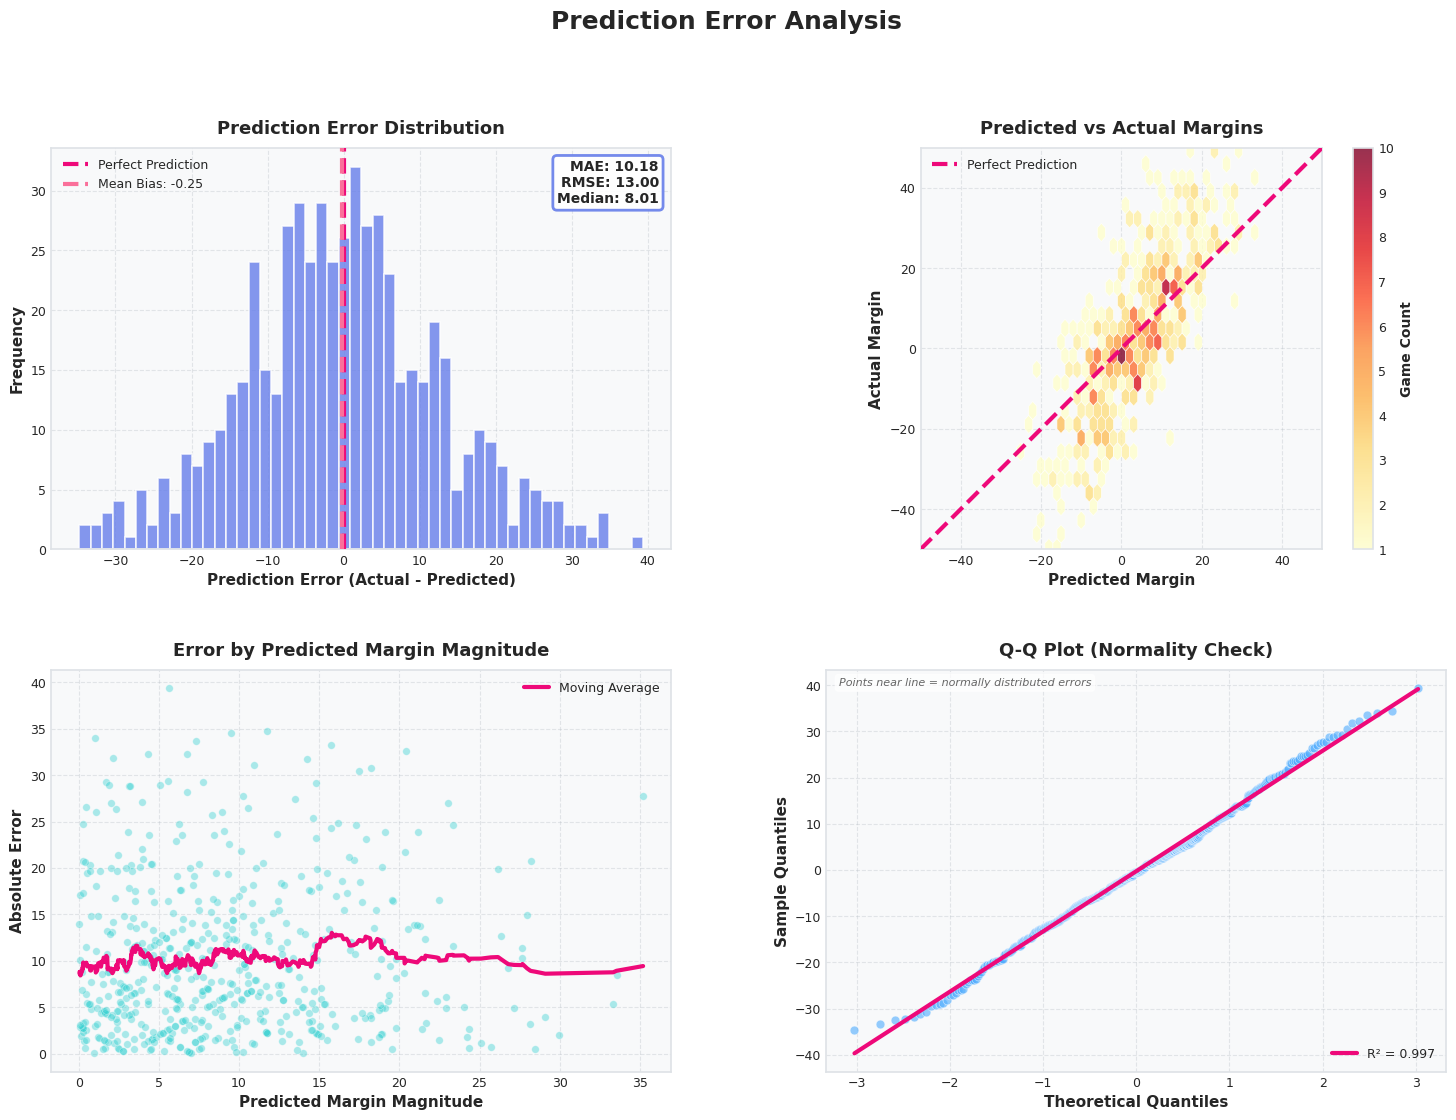

✅ Saved: data/output/visualizations/prediction_errors_2025.png


In [20]:
# Cell 9: Visualize Prediction Errors
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Prediction Error Analysis', fontsize=18, fontweight='bold', y=0.995)

# Create grid for subplots
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Plot 1: Residual distribution with modern styling
ax1.hist(residuals, bins=50, edgecolor='white', alpha=0.8, 
        color=COLORS['primary'], linewidth=1.2, density=False)
ax1.axvline(0, color=COLORS['danger'], linestyle='--', linewidth=3, 
           label='Perfect Prediction', zorder=10)
ax1.axvline(np.mean(residuals), color=COLORS['warning'], linestyle='--', 
           linewidth=3, label=f'Mean Bias: {np.mean(residuals):.2f}', zorder=10)

# Add statistical info box
stats_text = f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMedian: {median_error:.2f}'
ax1.text(0.98, 0.97, stats_text, transform=ax1.transAxes, 
        fontsize=10, fontweight='bold', va='top', ha='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor=COLORS['primary'], linewidth=2))

ax1.set_xlabel('Prediction Error (Actual - Predicted)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Prediction Error Distribution', fontsize=13, fontweight='bold', pad=10)
ax1.legend(loc='upper left', framealpha=0.95, edgecolor='#dee2e6')
ax1.set_facecolor('#f8f9fa')
ax1.grid(True, alpha=0.3)

# Plot 2: Predicted vs Actual with hexbin for density
hb = ax2.hexbin(predicted_margins, actual_margins, gridsize=30, cmap='YlOrRd', 
               mincnt=1, alpha=0.8, edgecolors='white', linewidths=0.5)
ax2.plot([-50, 50], [-50, 50], color=COLORS['danger'], linestyle='--', 
        linewidth=3, label='Perfect Prediction', zorder=10)

# Add colorbar
cb = plt.colorbar(hb, ax=ax2)
cb.set_label('Game Count', fontsize=10, fontweight='bold')

ax2.set_xlabel('Predicted Margin', fontsize=11, fontweight='bold')
ax2.set_ylabel('Actual Margin', fontsize=11, fontweight='bold')
ax2.set_title('Predicted vs Actual Margins', fontsize=13, fontweight='bold', pad=10)
ax2.legend(loc='upper left', framealpha=0.95, edgecolor='#dee2e6')
ax2.set_facecolor('#f8f9fa')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-50, 50)
ax2.set_ylim(-50, 50)
ax2.set_aspect('equal')

# Plot 3: Error by predicted margin with regression
ax3.scatter(np.abs(predicted_margins), np.abs(residuals), alpha=0.4, 
           s=30, color=COLORS['info'], edgecolors='white', linewidth=0.5)

# Add moving average trend
from scipy.ndimage import uniform_filter1d
sorted_indices = np.argsort(np.abs(predicted_margins))
x_sorted = np.abs(predicted_margins)[sorted_indices]
y_sorted = np.abs(residuals)[sorted_indices]
window = min(50, len(x_sorted) // 10)
if window > 2:
    y_smooth = uniform_filter1d(y_sorted, size=window)
    ax3.plot(x_sorted, y_smooth, color=COLORS['danger'], linewidth=3, 
            label='Moving Average', zorder=10)

ax3.set_xlabel('Predicted Margin Magnitude', fontsize=11, fontweight='bold')
ax3.set_ylabel('Absolute Error', fontsize=11, fontweight='bold')
ax3.set_title('Error by Predicted Margin Magnitude', fontsize=13, fontweight='bold', pad=10)
ax3.legend(framealpha=0.95, edgecolor='#dee2e6')
ax3.set_facecolor('#f8f9fa')
ax3.grid(True, alpha=0.3)

# Plot 4: Q-Q plot with enhanced styling
from scipy import stats as sp_stats
(osm, osr), (slope, intercept, r) = sp_stats.probplot(residuals, dist='norm', plot=None)
ax4.scatter(osm, osr, alpha=0.6, s=40, color=COLORS['success'], 
           edgecolors='white', linewidth=0.5)
ax4.plot(osm, slope * osm + intercept, color=COLORS['danger'], 
        linewidth=3, label=f'R² = {r**2:.3f}', zorder=10)

ax4.set_xlabel('Theoretical Quantiles', fontsize=11, fontweight='bold')
ax4.set_ylabel('Sample Quantiles', fontsize=11, fontweight='bold')
ax4.set_title('Q-Q Plot (Normality Check)', fontsize=13, fontweight='bold', pad=10)
ax4.legend(framealpha=0.95, edgecolor='#dee2e6')
ax4.set_facecolor('#f8f9fa')
ax4.grid(True, alpha=0.3)

# Add interpretation text
interpretation = 'Points near line = normally distributed errors'
ax4.text(0.02, 0.98, interpretation, transform=ax4.transAxes, 
        fontsize=8, style='italic', alpha=0.7, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.savefig(viz_dir / f'prediction_errors_{year}.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f'✅ Saved: {viz_dir}/prediction_errors_{year}.png')

## Home Field Advantage

In [21]:
# Cell 10: Analyze Home Field Advantage
# Split games by home/away/neutral
home_games = games_df[~games_df['neutral_site']]
neutral_games = games_df[games_df['neutral_site']]

# Calculate home win rate
home_wins = (home_games['home_score'] > home_games['away_score']).sum()
total_home_games = len(home_games)
home_win_pct = home_wins / total_home_games if total_home_games > 0 else 0

# Calculate neutral win rate (for "home" team designation)
neutral_wins = (neutral_games['home_score'] > neutral_games['away_score']).sum()
total_neutral_games = len(neutral_games)
neutral_win_pct = neutral_wins / total_neutral_games if total_neutral_games > 0 else 0

# Calculate average margins
home_margins = home_games['home_score'] - home_games['away_score']
neutral_margins = neutral_games['home_score'] - neutral_games['away_score']

avg_home_margin = home_margins.mean()
avg_neutral_margin = neutral_margins.mean()

print('='*80)
print('HOME FIELD ADVANTAGE ANALYSIS')
print('='*80)
print()
print(f'Home Games: {total_home_games}')
print(f'Home Win Rate: {home_win_pct:.1%}')
print(f'Average Home Margin: {avg_home_margin:.2f} points')
print()
print(f'Neutral Site Games: {total_neutral_games}')
print(f'Neutral "Home" Win Rate: {neutral_win_pct:.1%}')
print(f'Average Neutral Margin: {avg_neutral_margin:.2f} points')
print()
print(f'Implied HFA: {avg_home_margin - avg_neutral_margin:.2f} points')
print(f'Model HFA: 3.75 points')

HOME FIELD ADVANTAGE ANALYSIS

Home Games: 547
Home Win Rate: 57.2%
Average Home Margin: 3.56 points

Neutral Site Games: 10
Neutral "Home" Win Rate: 40.0%
Average Neutral Margin: -4.00 points

Implied HFA: 7.56 points
Model HFA: 3.75 points


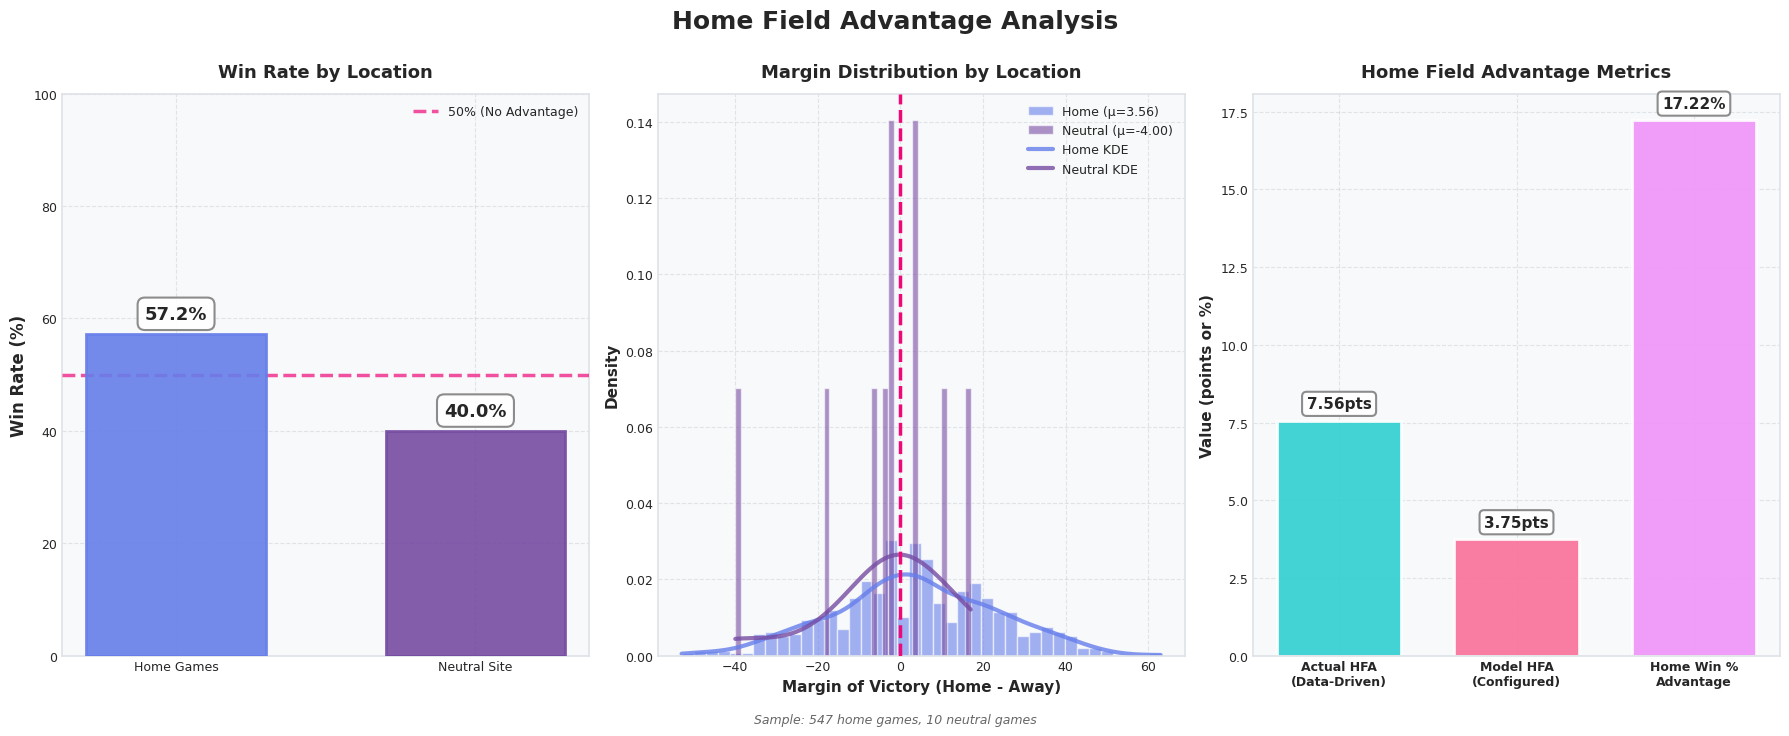

✅ Saved: data/output/visualizations/home_field_advantage_2025.png

📊 Key Insights:
   • Home teams win 57.2% of games vs 40.0% at neutral sites
   • Implied HFA: 7.56 points
   • Model uses: 3.75 points (industry standard)


In [22]:
# Cell 11: Visualize Home Field Advantage
fig = plt.figure(figsize=(18, 7))
fig.suptitle('Home Field Advantage Analysis', fontsize=18, fontweight='bold', y=1.00)

# Create subplots
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

# Plot 1: Win rate comparison with modern styling
locations = ['Home Games', 'Neutral Site']
win_rates = [home_win_pct * 100, neutral_win_pct * 100]
colors_bars = [COLORS['primary'], COLORS['secondary']]

bars = ax1.bar(locations, win_rates, color=colors_bars, 
              edgecolor='white', linewidth=2, width=0.6, alpha=0.9)

# Add gradient effect to bars
for bar, color in zip(bars, colors_bars):
    bar.set_color(color)
    bar.set_zorder(10)

ax1.axhline(50, color=COLORS['danger'], linestyle='--', linewidth=2.5, 
           label='50% (No Advantage)', zorder=5, alpha=0.7)
ax1.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Win Rate by Location', fontsize=13, fontweight='bold', pad=12)
ax1.set_ylim(0, 100)
ax1.legend(framealpha=0.95, edgecolor='#dee2e6')
ax1.set_facecolor('#f8f9fa')
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add value labels with styled boxes
for bar, rate in zip(bars, win_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{height:.1f}%', ha='center', va='bottom', 
            fontsize=13, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                     alpha=0.9, edgecolor='gray', linewidth=1.5))

# Plot 2: Margin distribution with KDE overlay
ax2.hist(home_margins, bins=40, alpha=0.6, color=COLORS['primary'], 
        edgecolor='white', linewidth=1, label=f'Home (μ={avg_home_margin:.2f})', density=True)
ax2.hist(neutral_margins, bins=40, alpha=0.6, color=COLORS['secondary'], 
        edgecolor='white', linewidth=1, label=f'Neutral (μ={avg_neutral_margin:.2f})', density=True)

# Add KDE curves
from scipy.stats import gaussian_kde
if len(home_margins) > 1:
    kde_home = gaussian_kde(home_margins)
    x_range = np.linspace(home_margins.min(), home_margins.max(), 200)
    ax2.plot(x_range, kde_home(x_range), color=COLORS['primary'], 
            linewidth=3, alpha=0.8, label='Home KDE')

if len(neutral_margins) > 1:
    kde_neutral = gaussian_kde(neutral_margins)
    x_range_n = np.linspace(neutral_margins.min(), neutral_margins.max(), 200)
    ax2.plot(x_range_n, kde_neutral(x_range_n), color=COLORS['secondary'], 
            linewidth=3, alpha=0.8, label='Neutral KDE')

ax2.axvline(0, color=COLORS['danger'], linestyle='--', linewidth=2.5, zorder=5)
ax2.set_xlabel('Margin of Victory (Home - Away)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Density', fontsize=11, fontweight='bold')
ax2.set_title('Margin Distribution by Location', fontsize=13, fontweight='bold', pad=12)
ax2.legend(framealpha=0.95, edgecolor='#dee2e6', loc='upper right')
ax2.set_facecolor('#f8f9fa')
ax2.grid(True, alpha=0.3, linestyle='--')

# Plot 3: HFA Comparison - Model vs Actual
hfa_data = {
    'Actual HFA\n(Data-Driven)': avg_home_margin - avg_neutral_margin,
    'Model HFA\n(Configured)': 3.75,
    'Home Win %\nAdvantage': (home_win_pct - neutral_win_pct) * 100
}

bars3 = ax3.bar(range(len(hfa_data)), list(hfa_data.values()), 
               color=[COLORS['info'], COLORS['warning'], COLORS['accent']],
               edgecolor='white', linewidth=2, width=0.7, alpha=0.9)

ax3.set_xticks(range(len(hfa_data)))
ax3.set_xticklabels(list(hfa_data.keys()), fontsize=9, fontweight='bold')
ax3.set_ylabel('Value (points or %)', fontsize=11, fontweight='bold')
ax3.set_title('Home Field Advantage Metrics', fontsize=13, fontweight='bold', pad=12)
ax3.set_facecolor('#f8f9fa')
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add value labels
for bar, (key, val) in zip(bars3, hfa_data.items()):
    height = bar.get_height()
    unit = '%' if 'Win %' in key else 'pts'
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            f'{val:.2f}{unit}', ha='center', va='bottom', 
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     alpha=0.9, edgecolor='gray', linewidth=1.5))

# Add note about sample sizes
note_text = f'Sample: {total_home_games} home games, {total_neutral_games} neutral games'
fig.text(0.5, -0.02, note_text, ha='center', fontsize=9, style='italic', alpha=0.7)

plt.tight_layout()
plt.savefig(viz_dir / f'home_field_advantage_{year}.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f'✅ Saved: {viz_dir}/home_field_advantage_{year}.png')
print(f'\n📊 Key Insights:')
print(f'   • Home teams win {home_win_pct:.1%} of games vs {neutral_win_pct:.1%} at neutral sites')
print(f'   • Implied HFA: {avg_home_margin - avg_neutral_margin:.2f} points')
print(f'   • Model uses: 3.75 points (industry standard)')

---

Visualizations saved to `data/output/visualizations/`